In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
# for reference, because I never remember
# Creating a datetime object for December 1, 2015, at 22:08:00
# dt = datetime(2015, 12, 1, 22, 8, 0)

In [3]:
algae = pd.read_csv('habsos_20230714.csv', parse_dates=['SAMPLE_DATE'])

C:\Users\lowry\AppData\Local\Temp\ipykernel_37572\66257093.py:1: DtypeWarning: Columns (18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  algae = pd.read_csv('habsos_20230714.csv', parse_dates=['SAMPLE_DATE'])


In [4]:
#algaedropna = algae.dropna(subset=['SALINITY','WATER_TEMP'], how='any')

In [5]:
fl = algae.loc[algae['STATE_ID'] == 'FL']

In [6]:
#algae_ven_sar_dropna = algae_ven_sar.dropna(subset=['SALINITY','WATER_TEMP'], how='any').copy()

In [7]:
# for i in range(1953,2024):
#     print("num samples in " + str(i) + ": " + str(len(fl.loc[(fl.SAMPLE_DATE >= datetime(i,1,1)) & (fl.SAMPLE_DATE <= datetime(i+1,1,1))])))

### A spike is defined to be any data point that exceeds the average cell count up to the date of collection

In [8]:
#look for a spike relative to that year for now
def spike(catalog,year1,year2):
    catalogyearspikes = []
    for i in range(year1,year2):
        pastreadings = catalog.loc[(catalog.SAMPLE_DATE < datetime(i,1,1))]['CELLCOUNT']
        peakmetric = pastreadings.mean()+1 #peak is defined as greater than the mean
        spikes = len(catalog.loc[(catalog.SAMPLE_DATE >= datetime(i,1,1)) 
                      & (catalog.SAMPLE_DATE < datetime(i+1,1,1))
                      & (catalog.CELLCOUNT>=peakmetric)]['CELLCOUNT'])
        catalogyearspikes.append(spikes)
    return catalogyearspikes

In [9]:
fl_spikes = pd.DataFrame({'year': pd.date_range('1960', '2024', freq='Y'), 'num_spikes' : pd.Series(spike(fl, 1960, 2024))})

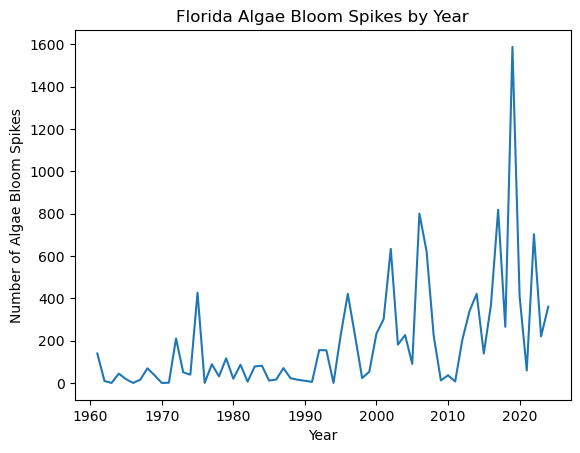

In [10]:
plt.plot(fl_spikes.year, fl_spikes.num_spikes)
plt.title('Florida Algae Bloom Spikes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Algae Bloom Spikes')
plt.show()

In [11]:
alg_train =  fl_spikes.loc[fl_spikes.year < datetime(2023, 1, 1)].copy()
alg_test = fl_spikes.drop(alg_train.index).copy()

## Average

In [12]:
train_avg = alg_train.num_spikes.mean()
train_avg

188.28571428571428

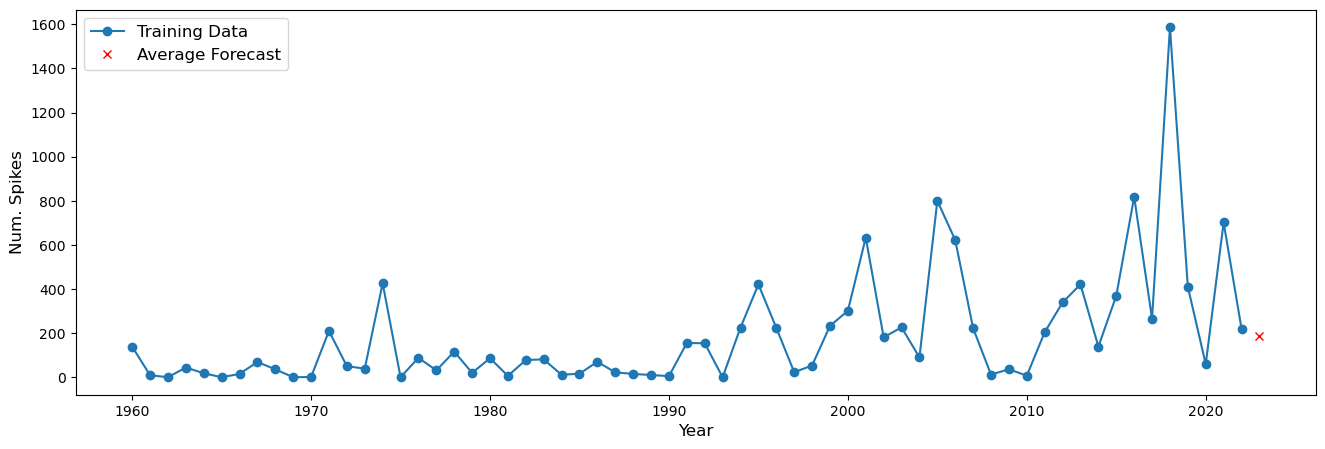

In [13]:
plt.figure(figsize=(16,5))

plt.plot([x.year for x in alg_train.year],
            alg_train.num_spikes,
            '-o',
            label = "Training Data")

plt.plot([2023], [train_avg], 'rx', label = 'Average Forecast') # 'rx' specifies a red x marker


plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Num. Spikes", fontsize=12)

    
plt.show()

## Naive

In [14]:
naive = alg_train.num_spikes.values[-1]

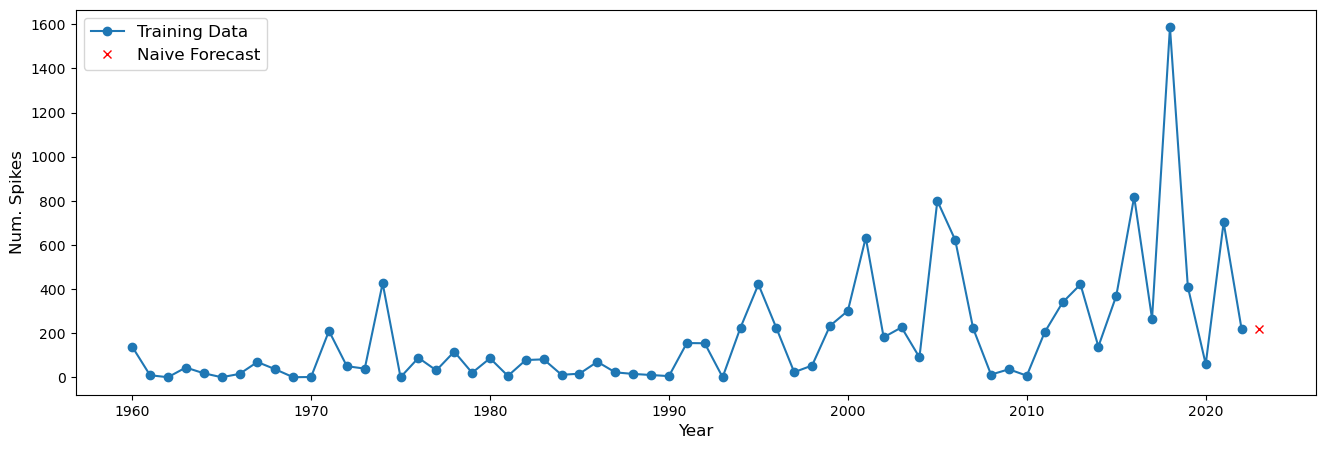

In [15]:
plt.figure(figsize=(16,5))

plt.plot([x.year for x in alg_train.year],
            alg_train.num_spikes,
            '-o',
            label = "Training Data")

plt.plot([2023], [naive], 'rx', label = 'Naive Forecast') # 'rx' specifies a red x marker


plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Num. Spikes", fontsize=12)

    
plt.show()

In [16]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [17]:
cv = TimeSeriesSplit(10, 
                     test_size=5)

In [18]:
avg_rmses = np.zeros(10)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index] #train set
    alg_ho = alg_train.iloc[test_index] #holdout set
    
    tt_avg = alg_tt.num_spikes.mean()
    
    avg_rmses[i] = np.sqrt(mean_squared_error(alg_ho.num_spikes.values,
                                    tt_avg*np.ones(5)))
    
    i = i + 1

In [19]:
np.mean(avg_rmses)

238.34268887424383

In [20]:
naive_rmses = np.zeros(10)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.loc[train_index] #train set
    alg_ho = alg_train.loc[test_index] #holdout set
    
    tt_naive = alg_tt.num_spikes.values[-1]
    
    naive_rmses[i] = np.sqrt(mean_squared_error(alg_ho.num_spikes.values,
                                    tt_naive*np.ones(5)))
    
    i = i + 1

In [21]:
np.mean(naive_rmses)

221.4057506224774

# models

In [22]:
# This function takes 3 numpy arrays as inputs.
# It returns the 
# mean absolute error of the forecast on the test set 
# relative to the
# mean absolute error of the naive forecast on the training set over an equivalent horizon.
# 
# If MASE > 1 then your forecast performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then your forecast performs better out of sample than naive forecast does in sample.

def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

## rolling average

In [23]:
cv = TimeSeriesSplit(10, test_size=5)

start = 2
end = 25
ra_mase = np.zeros((10, len(range(start, end))))


i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = alg_tt.num_spikes[-q:].mean() * np.ones(len(alg_ho))
        
        ra_mase[i,j] = mase(alg_tt.num_spikes.values, alg_ho.num_spikes.values, pred)
        j = j + 1
    i = i + 1

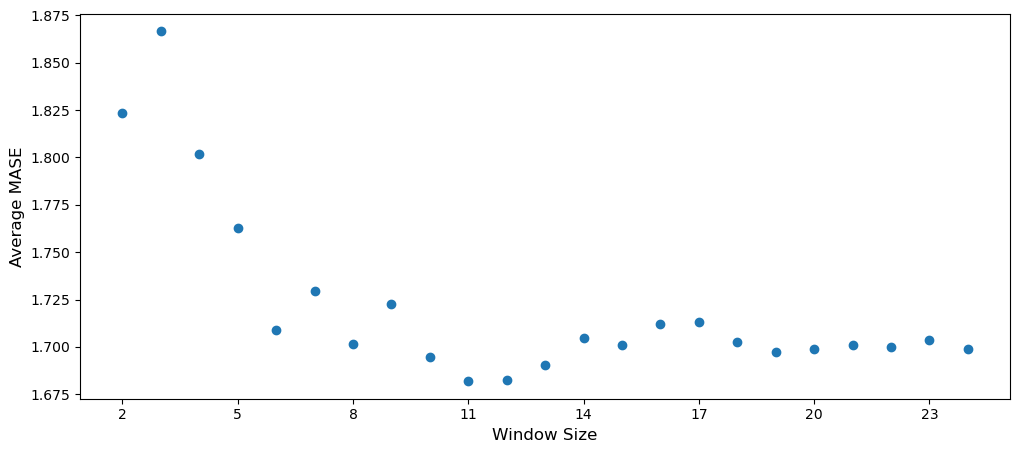

In [24]:
plt.figure(figsize=(12,5))

plt.scatter(range(start,end), np.mean(ra_mase, axis=0))

plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Average MASE", fontsize=12)

plt.xticks(range(start, end, 3), fontsize=10)
plt.yticks(fontsize=10)

plt.show()

So this does not perform better than the naive model

## exponential smoothing

In [25]:
## Importing the model from statsmodels
from statsmodels.tsa.api import SimpleExpSmoothing

In [26]:
exp_mase = np.zeros((10, len(np.arange(0, 0.95, .01))))

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for alpha in np.arange(0, 0.95, .01):
        exp_smooth = SimpleExpSmoothing(alg_tt.num_spikes.values).fit(smoothing_level=alpha,optimized=False)
        exp_mase[i,j] = mase(alg_tt.num_spikes.values, alg_ho.num_spikes.values, exp_smooth.forecast(len(alg_ho)))
        j = j + 1
    i = i + 1

In [27]:
## This gives us the indices of the smallest
## avg cv rmse
exp_ind = np.argmin(np.mean(exp_mase, axis=0))

In [28]:
print("The alpha value that give simple exponential",
         "smoothing model with lowest avg cv rmse is",
         "alpha = ", np.arange(0, 0.95, .01)[exp_ind])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_mase, axis=0)[exp_ind],5))

The alpha value that give simple exponential smoothing model with lowest avg cv rmse is alpha =  0.87
This model had an avg cv rmse of 1.66477


## double exponential smoothing

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

In [30]:
model = ExponentialSmoothing(alg_train.num_spikes.values, trend='add', seasonal=None)
model_fit = model.fit()

In [31]:
forecast = model_fit.forecast(len(alg_test.num_spikes.values))

In [50]:
forecast

array([507.28927472])

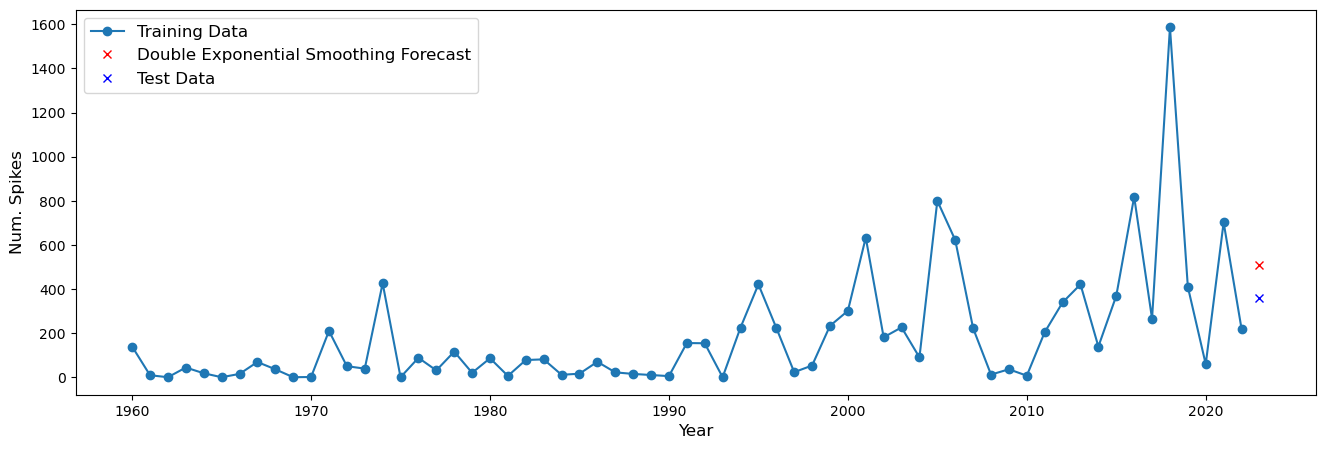

In [32]:
plt.figure(figsize=(16,5))

plt.plot([x.year for x in alg_train.year],
            alg_train.num_spikes,
            '-o',
            label = "Training Data")

plt.plot([2023], [forecast[0]], 'rx', label = 'Double Exponential Smoothing Forecast') # 'rx' specifies a red x marker
plt.plot([2023], alg_test.num_spikes.values, 'bx', label = 'Test Data')

plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Num. Spikes", fontsize=12)

    
plt.show()

In [56]:
def calculate_mase(actual_value, forecasted_value, last_observed_value):

    absolute_error_forecast = abs(actual_value - forecasted_value)
    
    absolute_error_naive = abs(actual_value - last_observed_value)
    
    mase = absolute_error_forecast / absolute_error_naive
    
    return mase


In [57]:
calculate_mase(alg_test.num_spikes.values[0], forecast[0], alg_train.num_spikes.values[-1])

1.052066247965414

## ARIMA

In [82]:
import statsmodels.api as sm

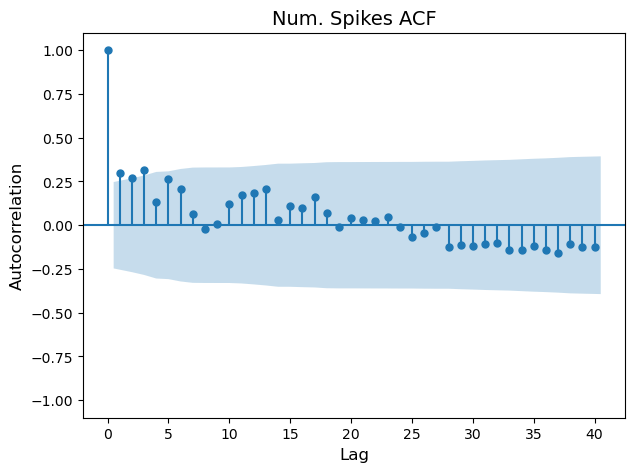

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

sm.graphics.tsa.plot_acf(alg_train.num_spikes,
                            lags = 40,
                            ax = ax)

plt.title('Num. Spikes ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

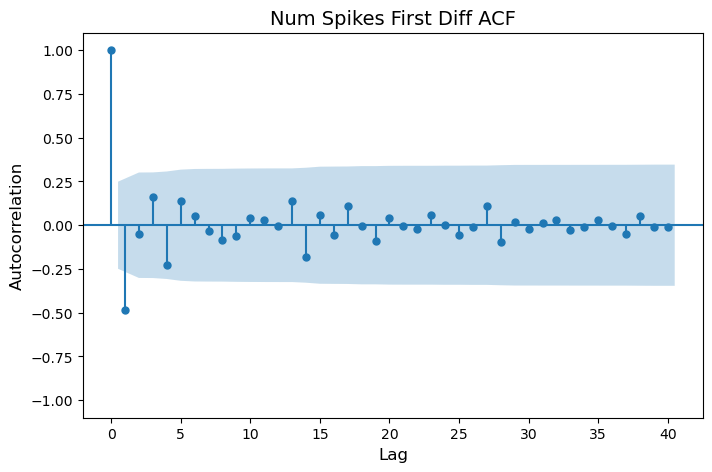

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

sm.graphics.tsa.plot_acf(alg_train.num_spikes.diff().values[1:],
                               lags=40,
                               ax=ax)

plt.title('Num Spikes First Diff ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

In [85]:
from statsmodels.tsa.api import ARIMA
from pmdarima import auto_arima

In [86]:
arima_mase = np.zeros((10, 4, 4))

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for p in range(4):
        k = 0
        for q in range(4):
            arima = ARIMA(alg_tt.num_spikes.values,
                               order=(p, 1, q)).fit()
            
            arima_mase[i,j,k] = mase(alg_tt.num_spikes.values, alg_ho.num_spikes.values,  arima.forecast(len(alg_ho)))
            k = k +1
        j = j + 1
    i = i +1

C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\base\model

In [87]:
arima_ind = np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None), 
                             np.mean(arima_mase, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None), 
                 np.mean(arima_mase, axis=0).shape)

(1, 2)

In [88]:
print("The parameters that give an ARIMA model",
         "with lowest avg cv mase are",
         "(p,d,q) = ( %s, %s, %s )" %(range(4)[arima_ind[0]], 1, range(4)[arima_ind[1]]))

print("This model had an avg cv mase of",
         np.round(np.mean(arima_mase, axis=0)[arima_ind],3))

The parameters that give an ARIMA model with lowest avg cv mase are (p,d,q) = ( 1, 1, 2 )
This model had an avg cv mase of 1.691


In [89]:
auto_arima(alg_train.num_spikes.values, trace=True, max_p=8, max_q=8)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=895.853, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=880.905, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=893.854, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=874.080, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=875.785, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=872.157, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=878.941, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=873.875, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=867.584, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=865.586, Time=0.04 sec
 A

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [90]:
arima_mase_auto = np.zeros((10))

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    arima = ARIMA(alg_tt.num_spikes.values,
                               order=(1, 1, 1)).fit()
    arima_mase_auto[i] = mase(alg_tt.num_spikes.values, alg_ho.num_spikes.values,  arima.forecast(len(alg_ho)))
            
    i = i +1

C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [91]:
arima_mase_auto.mean()

1.7332206817794695